In [1]:
import os
import random
import time
import itertools  
import numpy                 as np
import tensorflow            as tf
import matplotlib.pyplot     as plt
import pandas                as pd
import gudhi                 as gd
import gudhi.representations as sktda
import sys

from gudhi.representations.differentiation import LowerStarSimplexTreeModel as SimplexTreeModel
from gudhi.representations.differentiation import CubicalModel, RipsModel
from gudhi.representations.vector_methods import Atol as atol
from gudhi.representations.kernel_methods import SlicedWassersteinKernel as swk
from gudhi.wasserstein                    import wasserstein_distance
from gudhi.representations                import pairwise_persistence_diagram_distances as ppdd
from mpl_toolkits.mplot3d                 import Axes3D
from scipy.linalg                         import expm
from scipy.io                             import loadmat
from scipy.sparse                         import csgraph
from scipy.linalg                         import eigh
from sklearn.base                         import BaseEstimator, TransformerMixin
from sklearn.metrics                      import pairwise_distances, accuracy_score
from sklearn.manifold                     import MDS, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.preprocessing                import MinMaxScaler, Normalizer, LabelEncoder
from sklearn.pipeline                     import Pipeline, FeatureUnion
from sklearn.svm                          import SVC
from sklearn.ensemble                     import RandomForestClassifier
from sklearn.neighbors                    import KNeighborsClassifier
from sklearn.model_selection              import GridSearchCV, KFold, StratifiedKFold
from sklearn.cluster                      import KMeans

# Dimension Reduction

In this section, we implement the dimension reduction experiment, where we improve dimension reduction with autoencoders using 1-dimensional homology. Use `use_reg=True` if you want to add a topological loss to the autoencoder, and `common_topo_autoencoder=True` if you want to use the topological loss of Moor et al (https://arxiv.org/abs/1906.00722).

In [309]:
use_reg = True
common_topo_autoencoder = False

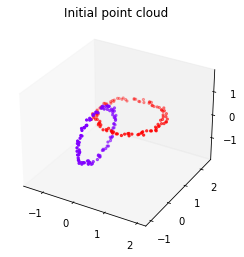

In [310]:
N = 100
eps = .1
Rell1x, Rell1y = 1, 1
theta1x, theta1y = 0, 0
Rell2x, Rell2y = .8, .6
theta2x, theta2y = -np.pi/4, -np.pi/6

np.random.seed(100)

angles = np.linspace(0,2*np.pi,N)[:,np.newaxis]
Rcic = 1.
cic = np.hstack([np.zeros([N,1]), 
                 Rcic * np.cos(angles) + eps * np.random.uniform(-1,1,(N,1)),
                 Rcic * np.sin(angles) + eps * np.random.uniform(-1,1,(N,1))])
ell1 = np.hstack([
    Rell1x * np.cos(angles) + eps * np.random.uniform(-1,1,(N,1)),
    Rell1y * np.sin(angles) + eps * np.random.uniform(-1,1,(N,1)),
    np.zeros([N,1])])
R1x = np.array([[1,0,0],[0,np.cos(theta1x),-np.sin(theta1x)],[0,np.sin(theta1x),np.cos(theta1x)]])
R1y = np.array([[np.cos(theta1y),0,np.sin(theta1y)],[0,1,0],[-np.sin(theta1y),0,np.cos(theta1y)]])
ell2 = np.hstack([
    Rell2x * np.cos(angles) + eps * np.random.uniform(-1,1,(N,1)),
    Rell2y * np.sin(angles) + eps * np.random.uniform(-1,1,(N,1)),
    np.zeros([N,1])])
R2x = np.array([[1,0,0],[0,np.cos(theta2x),-np.sin(theta2x)],[0,np.sin(theta2x),np.cos(theta2x)]])
R2y = np.array([[np.cos(theta2y),0,np.sin(theta2y)],[0,1,0],[-np.sin(theta2y),0,np.cos(theta2y)]])
ell1 = ell1 + np.array([[.3,.3,0.]])
ell2 = ell2 + np.array([[-.1,-.1,0.]])
Xinit = np.vstack([cic, cic[0,:] + np.dot(np.dot(ell1,R1x),R1y)]) #, cic[int(N/2),:] + np.dot(np.dot(ell2,R2x),R2y)])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(Xinit[:,0], Xinit[:,1], Xinit[:,2], 
                c=np.concatenate([np.ones([N]),2*np.ones([N])]), #3*np.ones([N])]), 
                s=5, cmap='rainbow')
x_limits, y_limits, z_limits = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
x_range, x_middle = abs(x_limits[1] - x_limits[0]), np.mean(x_limits)
y_range, y_middle = abs(y_limits[1] - y_limits[0]), np.mean(y_limits)
z_range, z_middle = abs(z_limits[1] - z_limits[0]), np.mean(z_limits)
plot_radius = 0.5*max([x_range, y_range, z_range])
ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
ax.grid(False)
plt.title('Initial point cloud')
plt.savefig('dimredinit_' + str(use_reg) + '.png')

In [311]:
Rot = []
for pt in Xinit:
    M = np.zeros((3,3))
    M[0,1] = pt[0]
    M[0,2] = pt[1]
    M[1,0] = -pt[0]
    M[2,0] = -pt[1]
    M[1,2] = pt[2]
    M[2,1] = -pt[2]
    Rot.append(expm(M).flatten())
Xinit = np.asarray(Rot)
Dinit = pairwise_distances(Xinit)

In [312]:
class IndexRipsModel(tf.keras.Model):
    def __init__(self, X, mel=12, dim=1, card=50):
        super(IndexRipsModel, self).__init__()
        self.X = X
        self.mel = mel
        self.dim = dim
        self.card = card
        
    def call(self, D):
        m, d, c = self.mel, self.dim, self.card
        
        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(self.X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        RipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        ids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(RipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        dgm = tf.reshape(tf.gather_nd(D, tf.reshape(ids, [2*c,2])), [c,2])
        return dgm

In [313]:
st = gd.RipsComplex(distance_matrix=Dinit, max_edge_length=2).create_simplex_tree(max_dimension=2)
st.persistence()
Dg1init = st.persistence_intervals_in_dimension(1)

initial_learning_rate = 0.05
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=1e5, decay_rate=0.99)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
Dg1iTF = tf.constant(np.array(Dg1init,dtype=np.float32))

seed = 0
tf.random.set_seed(seed)

autoencoder = tf.keras.models.Sequential()
autoencoder.add(tf.keras.Input(shape=(Xinit.shape[1],)))
autoencoder.add(tf.keras.layers.Dense(32, activation='relu'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.Dense(32, activation='relu'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.Dense(2, activation=None))
autoencoder.add(tf.keras.layers.Dense(32, activation='relu'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.Dense(32, activation='relu'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.Dense(Xinit.shape[1], activation=None))

reduced_data = tf.keras.Model(autoencoder.input, autoencoder.get_layer(index=4).output) 

Xred = reduced_data.predict(Xinit)
st = gd.RipsComplex(Xred, max_edge_length=2).create_simplex_tree(max_dimension=2)
st.persistence()
Dg1red = st.persistence_intervals_in_dimension(1)

a3 = 1
a2 = 1e1 if use_reg else 0
num_epochs = 200
losses, l2s, l3s, Dgs1, Xs = [], [], [], [], []
for epoch in range(num_epochs+1):
        
    with tf.GradientTape() as tape:
        
        XXinit = autoencoder(Xinit)
        Xred = reduced_data(Xinit)

        if use_reg and epoch >= 0:
            if common_topo_autoencoder:
                XinitTF = tf.convert_to_tensor(Xinit, dtype=tf.float32)
                DZ = tfa.losses.metric_learning.pairwise_distance(Xred)
                DX = tfa.losses.metric_learning.pairwise_distance(XinitTF)
                DZX = IndexRipsModel(X=Xred, mel=3.,  dim=0, card=50).call(DX)
                DZZ = IndexRipsModel(X=Xred, mel=3.,  dim=0, card=50).call(DZ)
                DXX = IndexRipsModel(X=XinitTF, mel=3., dim=0, card=50).call(DX)
                DXZ = IndexRipsModel(X=XinitTF, mel=3., dim=0, card=50).call(DZ)
            else:
                Dg1 = RipsModel(X=Xred, mel=3., dim=1, card=50).call()
                Dgs1.append(Dg1.numpy())
            
        Xs.append(Xred)
        l3 = a3*tf.math.reduce_sum(tf.square(Xinit-XXinit))

        if use_reg and epoch >= 0:
            if common_topo_autoencoder:
                l2 = tf.math.reduce_sum(tf.square(DXX-DXZ)) + tf.math.reduce_sum(tf.square(DZX-DZZ))
            else:
                l2 = a2*wasserstein_distance(Dg1, Dg1iTF, order=1, enable_autodiff=True)
                
        loss = l3

        if use_reg and epoch >= 0:
            loss = loss + l2
    
    gradients = tape.gradient(loss, autoencoder.trainable_variables)
    tf.random.set_seed(epoch)
    optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
    
    losses.append(loss.numpy())
    if use_reg and epoch >= 0:
        l2s.append(l2.numpy())
    l3s.append(l3.numpy())

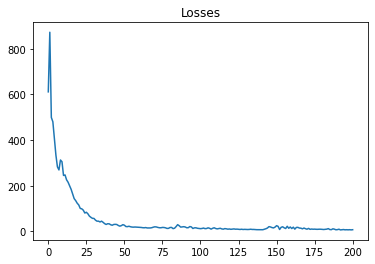

In [314]:
plt.figure()
plt.plot(losses)
plt.title('Losses')
plt.savefig('dimredloss_' + str(use_reg) + '.png')

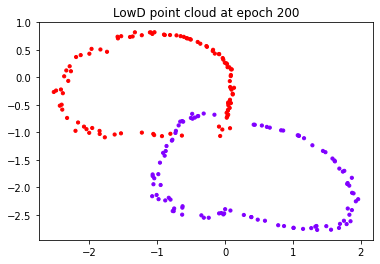

In [315]:
plt.figure()
plt.scatter(Xs[-1][:,0], Xs[-1][:,1], s=10, c=np.concatenate([np.ones([N]),2*np.ones([N])]), cmap='rainbow')
plt.title('LowD point cloud at epoch ' + str(epoch))
plt.savefig('dimredafter_' + str(use_reg) + '.png')

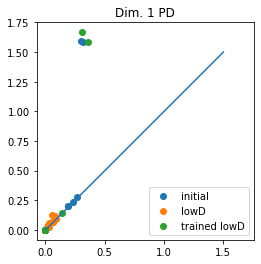

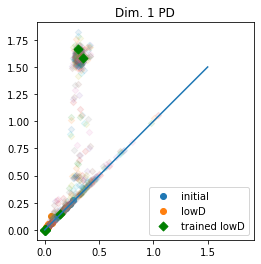

In [316]:
if use_reg and not common_topo_autoencoder:

    plt.figure()
    plt.scatter(Dg1init[:,0],  Dg1init[:,1],  label='initial')
    plt.scatter(Dg1red[:,0],   Dg1red[:,1],   label='lowD')
    plt.scatter(Dgs1[-1][:,0], Dgs1[-1][:,1], label='trained lowD')
    plt.plot([0,1.5],[0,1.5])
    plt.axis('square')
    plt.title('Dim. 1 PD')
    plt.legend()
    plt.savefig('dimreddg10_' + str(use_reg) + '.png')

    plt.figure()
    plt.scatter(Dg1init[:,0],  Dg1init[:,1],  label='initial')
    plt.scatter(Dg1red[:,0],   Dg1red[:,1],   label='lowD')
    for D in Dgs1[0:-1]:
        plt.scatter(D[:,0], D[:,1], s=20, marker='D', alpha=0.1)
    plt.scatter(Dgs1[-1][:,0], Dgs1[-1][:,1], s=40, marker='D', c='green', label='trained lowD')
    plt.plot([0,1.5],[0,1.5])
    plt.axis('square')
    plt.title('Dim. 1 PD')
    plt.legend()
    plt.savefig('dimreddg11_' + str(use_reg) + '.png')

# Regression

In this section, we implement the linear regression experiment, where we recover hidden coefficients using 0-dimensional homology.

In [16]:
np.random.seed(0)
n, p = 50, 100
betastar = np.concatenate([np.linspace(-1.,1.,33) for _ in range(3)] + [[-1.]])
X = np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n)

Y = np.matmul(X, betastar) + .05 * np.random.randn(n)
X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
stbase = gd.SimplexTree()
for i in range(p-1):
    stbase.insert([i,i+1], -1e10)
f = open('data/beta_simplextree.txt', 'w')
for (s,_) in stbase.get_filtration():
    for v in s:
        f.write(str(v) + " ")
    f.write("\n")
f.close()

betainit = np.random.uniform(low=-1., high=1., size=[p])
betainit[np.array([25,60,99])] = np.array([-1,-1,-1])

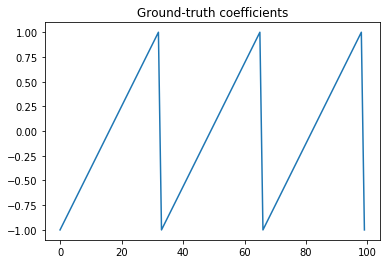

In [17]:
plt.figure()
plt.plot(betastar)
plt.title('Ground-truth coefficients')
plt.savefig('reggt.png')

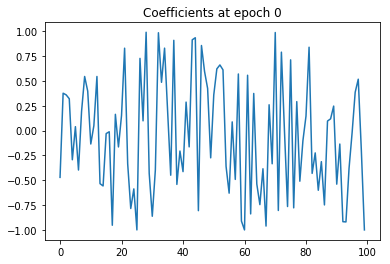

In [18]:
plt.figure()
plt.plot(betainit)
plt.title('Coefficients at epoch 0')
plt.savefig('reginit.png')

In [19]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
model = SimplexTreeModel(beta, stbase='data/beta_simplextree.txt', dim=0, card=100)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
sigma = 0.001

losses, dgms, betas = [], [], []
alpha, gamma, delta = 1, 1e4, 1e3
for epoch in range(100+1):
    
    with tf.GradientTape() as tape:
        
        dgm = model.call()
        loss = alpha * tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + gamma * tf.reduce_sum(tf.abs(dgm[2:,1]-dgm[2:,0])) \
             + delta * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
             
    gradients = tape.gradient(loss, model.trainable_variables)
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=sigma, size=gradients[0].shape)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    losses.append(loss.numpy())
    dgms.append(dgm)
    betas.append(beta.numpy()[:,0])

beta_stdtop = -betas[-1]

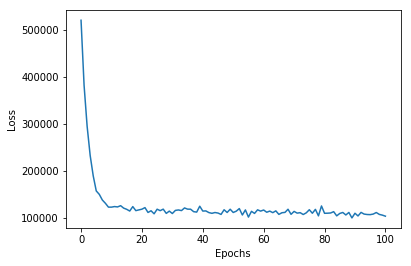

In [20]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('regloss.png')

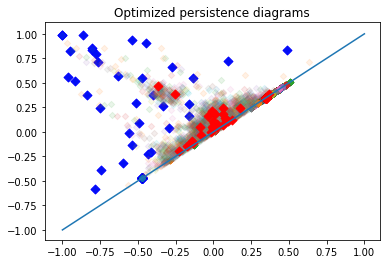

In [21]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([-1,1], [-1,1])
plt.title('Optimized persistence diagrams')
plt.savefig('regdg.png')

In [22]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
model = SimplexTreeModel(beta, stbase='data/beta_simplextree.txt', dim=0, card=100)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
sigma = 0.001

In [23]:
losses, dgms, betas = [], [], []
alpha, gamma, delta = 1, 0, 1e3
for epoch in range(100+1):
    
    with tf.GradientTape() as tape:
        
        dgm = model.call()
        loss = alpha * tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + gamma * tf.reduce_sum(tf.abs(dgm[2:,1]-dgm[2:,0])) \
             + delta * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
             
    gradients = tape.gradient(loss, model.trainable_variables)
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=sigma, size=gradients[0].shape)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    losses.append(loss.numpy())
    dgms.append(dgm)
    betas.append(beta.numpy()[:,0])
                 
beta_stdtot = -betas[-1]

beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
model = SimplexTreeModel(beta, stbase='data/beta_simplextree.txt', dim=0, card=100)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
sigma = 0.001

losses, dgms, betas = [], [], []
alpha, gamma, delta = 2, 0, 0
for epoch in range(100+1):
    
    with tf.GradientTape() as tape:
        
        dgm = model.call()
        loss = alpha * tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + gamma * tf.reduce_sum(tf.abs(dgm[2:,1]-dgm[2:,0])) \
             + delta * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
                     
    gradients = tape.gradient(loss, model.trainable_variables)
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=sigma, size=gradients[0].shape)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    losses.append(loss.numpy())
    dgms.append(dgm)
    betas.append(beta.numpy()[:,0])
    
beta_std = -betas[-1]

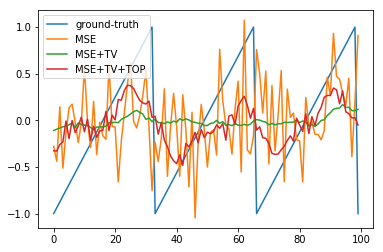

In [24]:
plt.figure()
plt.plot(betastar, label='ground-truth')
plt.plot(beta_std, label='MSE')
plt.plot(beta_stdtot, label='MSE+TV')
plt.plot(beta_stdtop, label='MSE+TV+TOP')
plt.legend(loc='upper left')
plt.savefig('regafter.png')

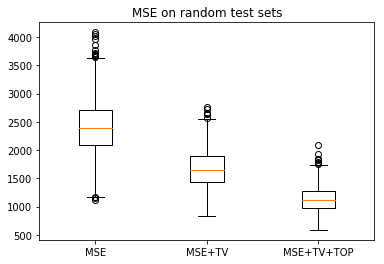

In [25]:
MSEstd, MSEtop, MSEtot = [], [], []
for s in range(1000):
    np.random.seed(s)
    Xnew = np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n)
    Ynew = np.matmul(Xnew, betastar)
    mse_std = np.square(np.matmul(Xnew, beta_std) - Ynew).sum()
    mse_tot = np.square(np.matmul(Xnew, beta_stdtot) - Ynew).sum()
    mse_top = np.square(np.matmul(Xnew, beta_stdtop) - Ynew).sum()
    MSEstd.append(mse_std)
    MSEtot.append(mse_tot)
    MSEtop.append(mse_top)
    
plt.figure()
plt.boxplot([MSEstd, MSEtot, MSEtop], labels=['MSE', 'MSE+TV', 'MSE+TV+TOP'])
plt.title('MSE on random test sets')
plt.savefig('regmse.png')

# Image

In this section, we implement the image experiment, where we remove the noise of an image using 0-dimensional homology. Use `use_reg=True` if you want to use a topological loss.

In [11]:
use_reg = 1

In [12]:
I = np.array(pd.read_csv('../../../../Documents/code/difftda/data/mnist_test.csv', header=None, sep=','), dtype=np.float32)
idx = np.argwhere(I[:,0] == 8)
image = np.reshape(-I[idx[8],1:], [28,28])
image = (image-image.min())/(image.max()-image.min())
image_clean = np.array(image)
image[2:5,2:5]        -= 0.6
image[25:27,25:27]    -= 0.6
image[25:27,2:5]      -= 0.6
image[1:4,24:26]      -= 0.6

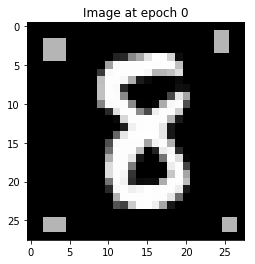

In [13]:
plt.figure()
plt.imshow(image, cmap='Greys')
plt.title('Image at epoch 0')
plt.savefig('imbefore_' + str(use_reg) + '.png')

In [14]:
X = tf.Variable(initial_value=np.array(image, dtype=np.float32), trainable=True)
model = CubicalModel(X, dim=0, card=100)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-3, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
sigma = 0.001

losses, dgms, empty = [], [], np.empty([0,2])
alpha = 10.
gamma = 1. if use_reg else 0
for epoch in range(3000+1):
    
    with tf.GradientTape() as tape:
        
        dgm = model.call()
        if use_reg:
            #loss = alpha * tf.math.reduce_sum(tf.abs(dgm[:,1]-dgm[:,0])) + \
            loss = gamma * tf.math.reduce_sum(tf.math.minimum(tf.abs(model.X), tf.abs(1.-model.X)))
        else:
            loss = alpha * tf.math.reduce_sum(tf.abs(dgm[:,1]-dgm[:,0]))

    gradients = tape.gradient(loss, model.trainable_variables)
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=sigma, size=gradients[0].shape)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    losses.append(loss.numpy())
    dgms.append(dgm)

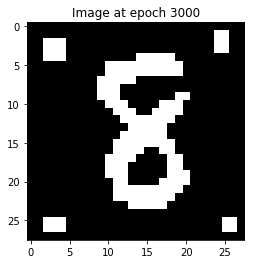

In [15]:
plt.figure()
plt.imshow(model.X.numpy(), cmap='Greys')
plt.title('Image at epoch ' + str(epoch))
plt.savefig('imafter_' + str(use_reg) + '.png')

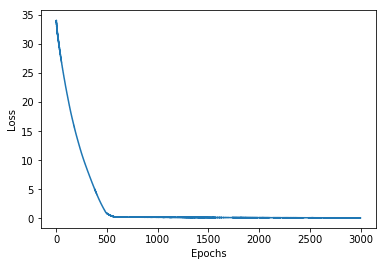

In [16]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('imloss_' + str(use_reg) + '.png')

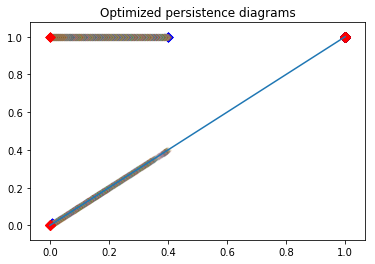

In [17]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([0,1], [0,1])
plt.title('Optimized persistence diagrams')
plt.savefig('imdg_' + str(use_reg) + '.png')

# Point cloud

In this section, we implement the point cloud experiment, where we optimize loops in a point cloud using 1-dimensional homology.

In [33]:
use_reg = 1

In [34]:
np.random.seed(1)
Xinit = np.array(np.random.uniform(high=1., low=-1., size=(300,2)), dtype=np.float32)

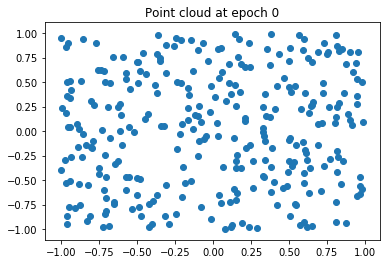

In [35]:
plt.figure()
plt.scatter(Xinit[:,0], Xinit[:,1])
plt.title('Point cloud at epoch 0')
plt.savefig('pcinit_' + str(use_reg) + '.png')

In [36]:
X = tf.Variable(initial_value=Xinit, trainable=True)
model = RipsModel(X=X, mel=12., dim=1, card=50)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.)
sigma = 0.001

losses, dgms = [], []
for epoch in range(1000+1):
    
    with tf.GradientTape() as tape:
        
        dgm = model.call()
        if use_reg:
            loss = -tf.math.reduce_sum(tf.square(.5*(dgm[:,1]-dgm[:,0]))) + tf.reduce_sum(tf.maximum(tf.abs(X)-1, 0))
        else:
            loss = -tf.math.reduce_sum(tf.square(.5*(dgm[:,1]-dgm[:,0])))

    gradients = tape.gradient(loss, model.trainable_variables)
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=sigma, size=gradients[0].shape)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    losses.append(loss.numpy())
    dgms.append(dgm)

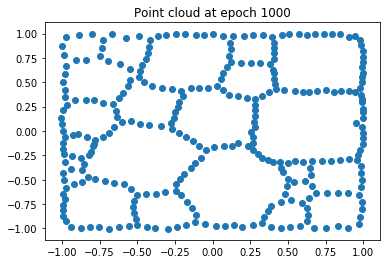

In [37]:
plt.figure()
plt.scatter(model.X.numpy()[:,0], model.X.numpy()[:,1])
plt.title('Point cloud at epoch ' + str(epoch))
plt.savefig('pcafter_' + str(use_reg) + '.png')

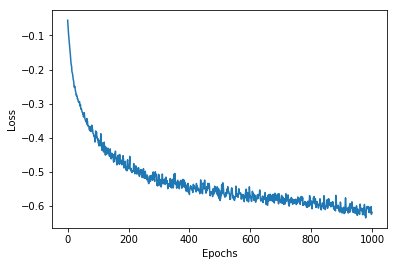

In [38]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('pcloss_' + str(use_reg) + '.png')

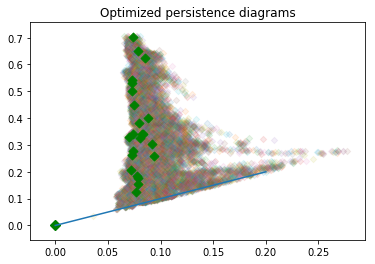

In [39]:
plt.figure()
for dg in dgms[:5:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='green')
plt.plot([-0.,.2], [-0.,.2])
plt.title('Optimized persistence diagrams')
plt.savefig('pcdg_' + str(use_reg) + '.png')

# Noisy point cloud

In this section, we implement the noisy point cloud experiment, where we optimize the connected components of a noisy point cloud using 0-dimensional homology.

In [61]:
n, epsilon, nout = 100, .2, 3
x, y = np.cos(np.linspace(0,2*np.pi,n)), np.sin(np.linspace(0,2*np.pi,n))
np.random.seed(10)
ex, ey = np.random.uniform(low=-epsilon,high=epsilon,size=n), np.random.uniform(low=-epsilon,high=epsilon,size=n)
outliers = np.random.uniform(low=-.7, high=.7, size=(nout,2))

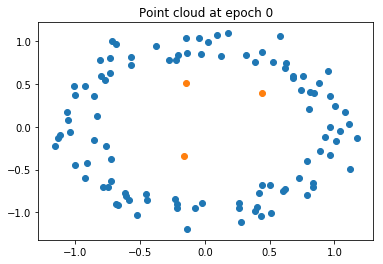

In [62]:
plt.figure()
plt.scatter(x+ex, y+ey)
plt.scatter(outliers[:,0], outliers[:,1])
plt.title('Point cloud at epoch 0')
plt.savefig('noisypcinit.png')

In [63]:
st = gd.RipsComplex(distance_matrix=pairwise_distances(np.hstack([x[:,np.newaxis],y[:,np.newaxis]])), max_edge_length=2.).create_simplex_tree(max_dimension=2)
st.persistence()
D = np.array(st.persistence_intervals_in_dimension(0), dtype=np.float32)[:-1]

In [64]:
Xinit = np.array(np.vstack([np.hstack([(x+ex)[:,np.newaxis], (y+ey)[:,np.newaxis]]),outliers]), dtype=np.float32)

X = tf.Variable(initial_value=Xinit, trainable=True)
model = RipsModel(X=X, mel=2., dim=0, card=150)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
sigma = 0.001

losses, dgms = [], []
for epoch in range(100+1):
    
    with tf.GradientTape() as tape:
        
        dgm = model.call()
        loss = tf.square(wasserstein_distance(dgm, tf.constant(D), order=2, enable_autodiff=True))
        
    gradients = tape.gradient(loss, model.trainable_variables)
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=sigma, size=gradients[0].shape)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    losses.append(loss.numpy())
    dgms.append(dgm)        

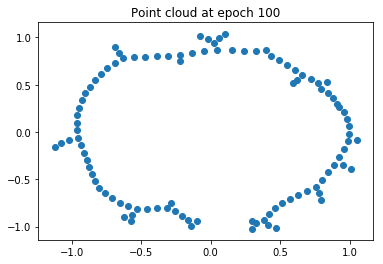

In [65]:
plt.figure()
plt.scatter(model.X.numpy()[:,0], model.X.numpy()[:,1])
plt.title('Point cloud at epoch ' + str(epoch))
plt.savefig('noisypcafter.png')

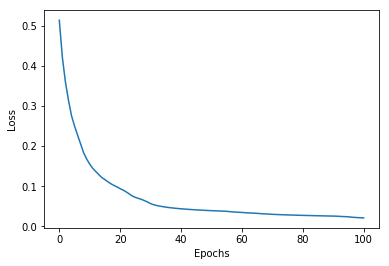

In [66]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('noisypcloss.png')

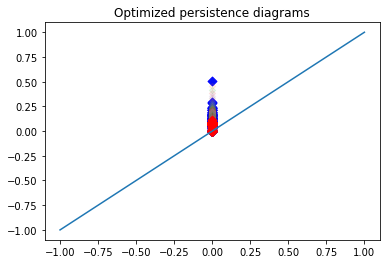

In [67]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([-1,1], [-1,1])
plt.title('Optimized persistence diagrams')
plt.savefig('noisypcdg.png')

# 3D shape

In this section, we implement the 3D shape experiment, where we optimize the values on a 3D shape using 0-dimensional homology.

In [68]:
faces, coord = np.loadtxt('data/human_faces', dtype=float)[:,1:], np.loadtxt('data/human_coords', dtype=float)
stbase = gd.SimplexTree()
for i in range(len(faces)):
    stbase.insert(faces[i,:], -1e10)
f = open('data/human_simplextree.txt', 'w')
for (s,_) in stbase.get_filtration():
    for v in s:
        f.write(str(v) + " ")
    f.write('\n')
f.close()
Finit = coord[:,2]

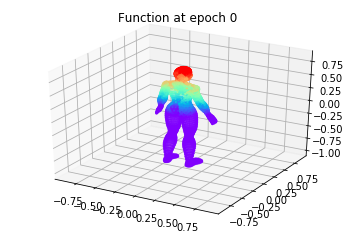

In [69]:
step = 1
fig = plt.figure()
cm = plt.cm.get_cmap('rainbow')
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(coord[::step,0], coord[::step,1], coord[::step,2], c=Finit[::step], s=2, 
                vmin=0, vmax=.75, cmap=cm)
x_limits, y_limits, z_limits = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
x_range, x_middle = abs(x_limits[1] - x_limits[0]), np.mean(x_limits)
y_range, y_middle = abs(y_limits[1] - y_limits[0]), np.mean(y_limits)
z_range, z_middle = abs(z_limits[1] - z_limits[0]), np.mean(z_limits)
plot_radius = 0.5*max([x_range, y_range, z_range])
ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
plt.title('Function at epoch 0')
plt.savefig('d3sinit.png')

In [70]:
F = tf.Variable(initial_value=np.array(Finit, dtype=np.float32), trainable=True)
model = SimplexTreeModel(F, stbase='data/human_simplextree.txt', dim=0, card=50)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
sigma = 0.001

losses, dgms = [], []
alpha, gamma = 1., .001
for epoch in range(3000+1):
    
    with tf.GradientTape() as tape:
        
        dgm = model.call()
        loss = alpha * tf.square(wasserstein_distance(dgm, tf.constant(np.array([[-.98,-.03]], dtype=np.float32)), order=2, enable_autodiff=True))               
    
    gradients = tape.gradient(loss, model.trainable_variables)
    np.random.seed(epoch)
    gradients = [tf.convert_to_tensor(gradients[0]) + np.random.normal(loc=0., scale=sigma, size=gradients[0].dense_shape)]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    losses.append(loss.numpy())
    dgms.append(dgm)

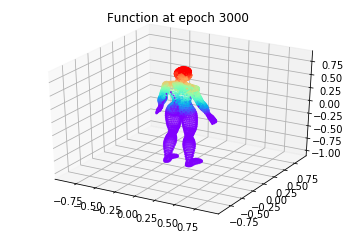

In [71]:
step = 1
fig = plt.figure()
cm = plt.cm.get_cmap('rainbow')
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(coord[::step,0], coord[::step,1], coord[::step,2], c=F.numpy()[::step], s=1, 
                vmin=0, vmax=.75, cmap=cm)
x_limits, y_limits, z_limits = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
x_range, x_middle = abs(x_limits[1] - x_limits[0]), np.mean(x_limits)
y_range, y_middle = abs(y_limits[1] - y_limits[0]), np.mean(y_limits)
z_range, z_middle = abs(z_limits[1] - z_limits[0]), np.mean(z_limits)
plot_radius = 0.5*max([x_range, y_range, z_range])
ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
plt.title('Function at epoch ' + str(epoch))
plt.savefig('d3safter.png')

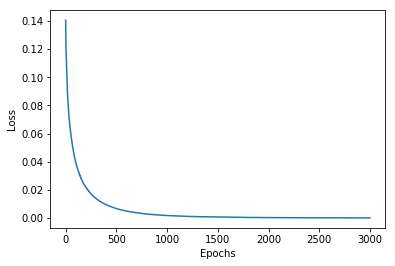

In [72]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('d3sloss.png')

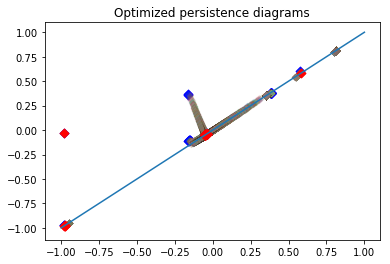

In [73]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1:2]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([-1,1], [-1,1])
plt.title('Optimized persistence diagrams')
plt.savefig('d3sdg.png')

# Filter selection

In this section, we implement the filter selection experiment, where we optimize a filter for classification using 0-dimensional homology.

In [2]:
class FiltrationSelector(BaseEstimator, TransformerMixin):

    def __init__(self, use=False, index_filt=0):
        self.use, self.idx = use, index_filt

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.use:
            Xfit = [D[self.idx] for D in X]
        else:
            Xfit = X
        return Xfit

In [13]:
dataset                   = '23'
step                      = 10
initial_learning_rate     = 0.001
batch_size                = 100
num_epochs                = 20
numdir                    = 10
hcard                     = 20
hdim                      = 0

In [14]:
thetainit = np.linspace(-np.pi/2, np.pi/2, num=numdir)
Cinit = np.array([0., np.pi/2])
num_filts = len(Cinit)
X = tf.keras.datasets.mnist.load_data()

In [15]:
l1, l2 = int(dataset[0]), int(dataset[1])
tridxs1, tridxs2 = np.argwhere(X[0][1] == l1).ravel()[::step], np.argwhere(X[0][1] == l2).ravel()[::step]
teidxs1, teidxs2 = np.argwhere(X[1][1] == l1).ravel()[::step], np.argwhere(X[1][1] == l2).ravel()[::step]
IMG = [X[0][0][j] for j in tridxs1]    + [X[0][0][j] for j in tridxs2]    + [X[1][0][j] for j in teidxs1]    + [X[1][0][j] for j in teidxs2]
LAB = [0 for _ in range(len(tridxs1))] + [1 for _ in range(len(tridxs2))] + [0 for _ in range(len(teidxs1))] + [1 for _ in range(len(teidxs2))]
ntrain = len(tridxs1) + len(tridxs2)
ntot = len(tridxs1) + len(tridxs2) + len(teidxs1) + len(teidxs2)
train_idxs, test_idxs = np.arange(0, ntrain), np.arange(ntrain, ntot)

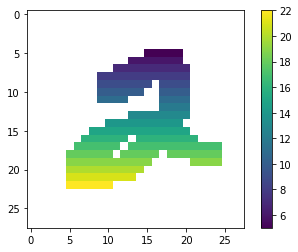

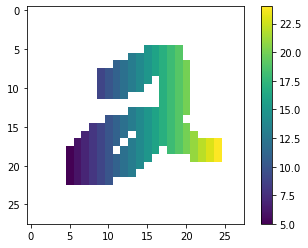

In [16]:
DGMb = []
for pdi in range(num_filts):
    DGMi = []
    for j, img in enumerate(IMG):
        inds = np.argwhere(img > 0)
        I = np.inf * np.ones(img.shape)
        for i in range(len(inds)):
            val = np.cos(Cinit[pdi])*inds[i,0] + np.sin(Cinit[pdi])*inds[i,1]
            I[inds[i,0], inds[i,1]] = val
        ccb = gd.CubicalComplex(top_dimensional_cells=I)
        ccb.persistence()
        dgmb = ccb.persistence_intervals_in_dimension(hdim)
        DGMi.append(dgmb)

        if j == 0:
            vm, vM = min(list(I[I!=np.inf].flatten())), max(list(I[I!=np.inf].flatten()))
            plt.figure()
            plt.imshow(I, vmin=vm, vmax=vM)
            plt.colorbar()
            plt.savefig(str(j) + '_' + '{:.2f}'.format(Cinit[pdi]) + '.png')

    DGMb.append(DGMi)

In [17]:
num_filts = len(DGMb)
num_diags = len(DGMb[0])
DGMb = [[DGMb[f][i] for f in range(num_filts)] for i in range(num_diags)]

train_dgmbs, test_dgmbs = [DGMb[i] for i in train_idxs], [DGMb[i] for i in test_idxs]
train_labs,  test_labs  = [LAB[i]  for i in train_idxs], [LAB[i]  for i in test_idxs]
le = LabelEncoder().fit(train_labs + test_labs)
train_labs, test_labs = le.transform(train_labs), le.transform(test_labs)

pipe = Pipeline([
    ('Feats', FeatureUnion([  ('Pipe' + str(nf), Pipeline([('Selector',  FiltrationSelector(index_filt=nf)),
                                                           ('Separator', sktda.DiagramSelector(limit=np.inf, point_type='finite')),
                                                           ('TDA',       sktda.Landscape())
                                                          ])) for nf in range(num_filts)
                           ])),
    ('Estimator', RandomForestClassifier())
])
param = {'Feats__Pipe0__Selector__use':        True,
         'Feats__Pipe0__Separator__use':       True,
         'Feats__Pipe0__TDA__resolution':      50,
         'Feats__Pipe0__TDA__num_landscapes':  5}
for nf in range(num_filts-1):
    newparam = {'Feats__Pipe' + str(nf+1) + '__Selector__use':        True,
                'Feats__Pipe' + str(nf+1) + '__Separator__use':       True,
                'Feats__Pipe' + str(nf+1) + '__TDA__resolution':      50,
                'Feats__Pipe' + str(nf+1) + '__TDA__num_landscapes':  5}
    param.update(newparam)
param['Estimator__random_state'] = 0

modelb = pipe.set_params(**param)
modelb.fit(train_dgmbs, train_labs)
trb = modelb.score(train_dgmbs, train_labs)
teb = modelb.score(test_dgmbs,  test_labs)
train_imgs = np.vstack([IMG[i].flatten()[np.newaxis,:] for i in train_idxs]) 
test_imgs  = np.vstack([IMG[i].flatten()[np.newaxis,:] for i in test_idxs])
rf = RandomForestClassifier().fit(train_imgs, train_labs)
trbb = rf.score(train_imgs, train_labs)
tebb = rf.score(test_imgs,  test_labs)

/home/mcarrier/.conda/envs/python3.8/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


In [18]:
C = tf.Variable(initial_value=np.array(Cinit, dtype=np.float32), trainable=True)
thetas = tf.Variable(initial_value=np.array(thetainit, dtype=np.float32), trainable=False)
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=1e5, decay_rate=0.99, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
batch_size = min(batch_size, len(train_idxs))

losses, coeffs, accs = [], [], []
for epoch in range(num_epochs+1):
    
    np.random.seed(int(1e2*epoch))
    batch = np.random.choice(train_idxs, batch_size, replace=False)
    batch_labs = [LAB[i] for i in batch]
    
    with tf.GradientTape() as tape:

        dists = []
        for nf in range(num_filts):
            
            dgms = []
            for i in batch:
                img = IMG[i]
                inds = np.argwhere(img > 0)
                IX, IY = 1e3 * np.ones(img.shape), 1e3 * np.ones(img.shape)
                for k in range(len(inds)):
                    IX[inds[k,0], inds[k,1]] = inds[k,0]
                    IY[inds[k,0], inds[k,1]] = inds[k,1]
                II = tf.math.cos(C[nf])*IX + tf.math.sin(C[nf])*IY
                dgm = CubicalModel(II, dim=hdim, card=hcard).call()
                dgms.append(dgm)
        
            proj_dgms = tf.linalg.matmul(tf.concat(dgms,axis=0), .5*tf.ones([2,2], tf.float32))
            dgms_big = tf.concat([tf.reshape(tf.concat([
                dgm, proj_dgms[:hcard*idg], proj_dgms[hcard*(idg+1):]
            ], axis=0), [-1,2,1,1]) for idg, dgm in enumerate(dgms)], axis=2)
            cosines, sines = tf.math.cos(thetas), tf.math.sin(thetas)
            vecs = tf.concat([tf.reshape(cosines,[1,1,1,-1]), tf.reshape(sines,[1,1,1,-1])], axis=1)
            theta_projs = tf.sort(tf.math.reduce_sum(tf.math.multiply(dgms_big,vecs), axis=1), axis=0)
            t1 = tf.reshape(theta_projs, [hcard*batch_size,-1,1,numdir])
            t2 = tf.reshape(theta_projs, [hcard*batch_size,1,-1,numdir])
            dists.append(tf.math.reduce_mean(tf.math.reduce_sum(tf.math.abs(t1-t2), axis=0), axis=2))

        loss = 0.
        classes = np.unique(batch_labs)
        for l in classes:
            lidxs = np.argwhere(np.array(batch_labs) == l).ravel()
            idxs1 = list(itertools.product(lidxs, lidxs))
            idxs2 = list(itertools.product(lidxs, range(batch_size)))
            for nf in range(num_filts):
                cost1 = tf.math.reduce_sum(tf.gather_nd(dists[nf], idxs1))
                cost2 = tf.math.reduce_sum(tf.gather_nd(dists[nf], idxs2))
                loss += cost1 / cost2
    
    gradients = tape.gradient(loss, [C]) 
    optimizer.apply_gradients(zip(gradients, [C]))
    curr_coeff = C.numpy().flatten()
    losses.append(loss.numpy())
    coeffs.append(curr_coeff)
    if epoch % 10 == 0:

        final_coeff = C.numpy()

        DGM = []
        for nf in range(num_filts):
            DGMi = []
            for i, img in enumerate(IMG):
                inds = np.argwhere(img > 0)
                I = np.inf * np.ones(img.shape)
                for i in range(len(inds)):
                    val = np.cos(final_coeff[nf])*inds[i,0] + np.sin(final_coeff[nf])*inds[i,1]
                    I[inds[i,0], inds[i,1]] = val
                cc = gd.CubicalComplex(top_dimensional_cells=I)
                cc.persistence()
                dgm = cc.persistence_intervals_in_dimension(hdim)
                DGMi.append(dgm)
            DGM.append(DGMi)

        num_filts = len(DGM)
        num_diags = len(DGM[0])
        DGM = [[DGM[f][i] for f in range(num_filts)] for i in range(num_diags)]
        train_dgms, test_dgms = [DGM[i] for i in train_idxs], [DGM[i] for i in test_idxs]
        model = pipe.set_params(**param)
        model.fit(train_dgms, train_labs)
        tr = model.score(train_dgms, train_labs)
        te = model.score(test_dgms,  test_labs)

        accs.append([trbb, tebb, trb, teb, tr, te])

/home/mcarrier/.conda/envs/python3.8/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/mcarrier/.conda/envs/python3.8/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/mcarrier/.conda/envs/python3.8/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


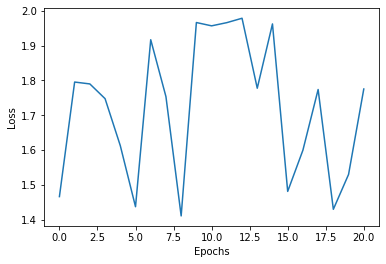

In [19]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('fltloss.png')

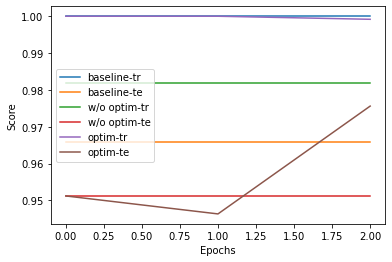

In [20]:
plt.figure()
plt.plot([accs[i][0] for i in range(len(accs))], label='baseline-tr')
plt.plot([accs[i][1] for i in range(len(accs))], label='baseline-te')
plt.plot([accs[i][2] for i in range(len(accs))], label='w/o optim-tr')
plt.plot([accs[i][3] for i in range(len(accs))], label='w/o optim-te')
plt.plot([accs[i][4] for i in range(len(accs))], label='optim-tr')
plt.plot([accs[i][5] for i in range(len(accs))], label='optim-te')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.savefig('fltacc.png')

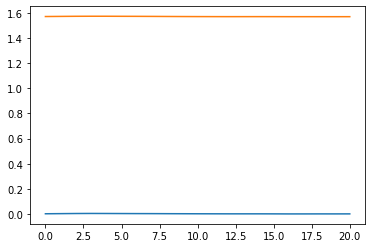

In [21]:
CS = np.array(coeffs)
plt.figure()
for c in range(CS.shape[1]):
    plt.plot(CS[:,c])
plt.savefig('fltcoeff.png')